In [16]:
pip install pyserini

Note: you may need to restart the kernel to use updated packages.


In [17]:
import pandas as pd
import numpy as np
from pyserini.search.lucene import LuceneSearcher

In [18]:
pip install scrapy

Note: you may need to restart the kernel to use updated packages.


In [19]:
import scrapy
class WikiSpider(scrapy.Spider):
    name = "wiki_spider"
    start_urls = ['https://en.wikipedia.org/wiki/Law']

    # scrapy settings. scrapy runspider looks for variable called "custom_settings" as a dictionary with specific keys
    custom_settings = {
        'CLOSESPIDER_PAGECOUNT': 100000, # stops running after reaching pagecount value
        'CONCURRENT_REQUESTS': 16, # allows the spider to download 16 pages at the same time. This is standard and keeps wiki from blocking the bot
        'FEEDS': {'wiki_data2.jsonl': {'format': 'jsonlines', 'overwrite': True}}, # handles the file saving for so i don't have to write open() or write() in the code
        'ROBOTSTXT_OBEY': False, # ignores wiki's rules for bots scraping
        'DEPTH_PRIORITY': 1, # prioritize shallow links to keep the content as relevant to 'law' as possible
        # force first-in-first-out queue to keep the content more relevant
        'SCHEDULER_DISK_QUEUE': 'scrapy.squeues.PickleFifoDiskQueue', # store urls in RAM
        'SCHEDULER_MEMORY_QUEUE': 'scrapy.squeues.FifoMemoryQueue', # If RAM gets full, Scrapy dumps the overflow URLs onto your Hard Drive
    }

    def parse(self, response):
        # get title
        # 'string()' operates like a function and grabs text even if it's trapped inside a <span> tag.
        # Ttakes the H1 element and converts the entire tree structure into a single flat string.
        # uses universal xpath formula //tag[@attribute=value] so that its applcable to all titles
        # html attribute and value for title is id="firstHeading". Use inspect on wiki page to get this
        title = response.xpath('string(//h1[@id="firstHeading"])').get()

        # get text data
        # Grab every <p>, convert to string, join them, and clean whitespace
        # div#mw-content-text is the name for the main body of the page
        raw_text = [p.xpath('string(.)').get() for p in response.css('div#mw-content-text p')]
        text_content = " ".join(" ".join(raw_text).split())

        # save and set limit to wiki pages with over 500 words
        if title and len(text_content) > 500:
            yield {
                'url': response.url,
                'title': title,
                'text': text_content
            }

        # Follow Links
        # CSS telling crawler to look inside the body of the wiki page (div#mw-content-text this can be
        # found using inspector on the wiki page). this looks for <div>, then identifies id mw-content-text
        # a::attr(href) tells it to find the url in the body and go there
        for link in response.css('div#mw-content-text a::attr(href)').getall():
            if link.startswith('/wiki/') and ':' not in link:
                yield response.follow(link)

In [20]:
import json
import os
import subprocess
from pyserini.search.lucene import LuceneSearcher

# Creates a folder called "input" to store the json file being indexed using pyserini
os.makedirs("input", exist_ok=True)

# Convert output into pyserini format (url, title, and text)
with open("wiki_data2.jsonl", "r", encoding="utf-8") as wiki_file, \
     open("input/wiki_docs2.jsonl", "w", encoding="utf-8") as dest_file:

# Apply to each line in each scrapped wikipidia page
    for line in wiki_file:
        data = json.loads(line)

        # Create Pyserini document
        pyserini_doc = {
            "id": data["url"],            # url acts as unique identifier
            "contents": data["text"],     # contents to be indexed
            "title": data["title"]        # title
        }

        # Write JSON object per line
        dest_file.write(json.dumps(pyserini_doc) + "\n")


# Build Lucene index
command = [
    "python", "-m", "pyserini.index.lucene",
    "--collection", "JsonCollection", # input format
    "--input", "input", # directory containing jsonl docs
    "--index", "indexes/wiki_index", # output into indexes/wiki_index folder
    "--generator", "DefaultLuceneDocumentGenerator", 
    "--threads", "1",
    "--storePositions",
    "--storeDocvectors",
    "--storeRaw"
]

# Run commands
subprocess.run(command, check=True)

2026-01-27 16:40:48,077 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:205) - Setting log level to INFO
2026-01-27 16:40:48,078 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:208) - ============ Loading Index Configuration ============
2026-01-27 16:40:48,078 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:209) - AbstractIndexer settings:
2026-01-27 16:40:48,078 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:210) -  + DocumentCollection path: input
2026-01-27 16:40:48,078 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:211) -  + CollectionClass: JsonCollection
2026-01-27 16:40:48,078 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:212) -  + Index path: indexes/wiki_index
2026-01-27 16:40:48,078 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:213) -  + Threads: 1
2026-01-27 16:40:48,078 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:214) -  + Optimize (merge segments)? false
2026-01-27 16:40:48,090 INFO  [main] 

Jan 27, 2026 4:40:48 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false


2026-01-27 16:41:28,296 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:307) - Indexing Complete! 43,667 documents indexed
2026-01-27 16:41:28,297 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:308) - ============ Final Counter Values ============
2026-01-27 16:41:28,297 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:309) - indexed:           43,667
2026-01-27 16:41:28,297 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:310) - unindexable:            0
2026-01-27 16:41:28,297 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:311) - empty:                  0
2026-01-27 16:41:28,297 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:312) - skipped:                0
2026-01-27 16:41:28,297 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:313) - errors:                 0
2026-01-27 16:41:28,299 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:316) - Total 43,667 documents indexed in 00:00:40


CompletedProcess(args=['python', '-m', 'pyserini.index.lucene', '--collection', 'JsonCollection', '--input', 'input', '--index', 'indexes/wiki_index', '--generator', 'DefaultLuceneDocumentGenerator', '--threads', '1', '--storePositions', '--storeDocvectors', '--storeRaw'], returncode=0)

In [21]:
# Load LuceneSearcher
searcher = LuceneSearcher("indexes/wiki_index")

# State keyword query
query = "constitutional law"
hits = searcher.search(query) # Search for stated query

# for each hit, retrieve the stored raw docuemnts, extract the title, and print rank, score, url, and title
# loops over each retrived document
for i, hit in enumerate(hits):
    doc = searcher.doc(hit.docid)

    if doc is not None:
        doc_json = json.loads(doc.raw()) # load raw doc
        title = doc_json.get("title", "No title") # extracts title from doc
    else:
        title = "No doc found" # return if no title is found

    # Print results
    print(
        f"{i+1:<3} "
        f"Score: {hit.score:.4f} "
        f"URL: {hit.docid} "
        f"Title: {title}"
    )

1   Score: 1.7082 URL: https://en.wikipedia.org/wiki/Codified_constitution Title: Constitution
2   Score: 1.7082 URL: https://en.wikipedia.org/wiki/Constitution Title: Constitution
3   Score: 1.7082 URL: https://en.wikipedia.org/wiki/Constitutional_democracy Title: Constitution
4   Score: 1.7082 URL: https://en.wikipedia.org/wiki/Codified_constitution Title: Constitution
5   Score: 1.7082 URL: https://en.wikipedia.org/wiki/Constitution Title: Constitution
6   Score: 1.7082 URL: https://en.wikipedia.org/wiki/Constitutional_democracy Title: Constitution
7   Score: 1.7082 URL: https://en.wikipedia.org/wiki/Constitutions Title: Constitution
8   Score: 1.7071 URL: https://en.wikipedia.org/wiki/Constitution_of_Singapore Title: Constitution of Singapore
9   Score: 1.7048 URL: https://en.wikipedia.org/wiki/Judicial_review_in_the_United_States Title: Judicial review in the United States
10  Score: 1.7048 URL: https://en.wikipedia.org/wiki/Judicial_review_in_the_United_States Title: Judicial rev

2026-01-27 16:41:30,335 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:205) - Setting log level to INFO
2026-01-27 16:41:30,336 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:208) - ============ Loading Index Configuration ============
2026-01-27 16:41:30,336 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:209) - AbstractIndexer settings:
2026-01-27 16:41:30,336 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:210) -  + DocumentCollection path: input
2026-01-27 16:41:30,336 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:211) -  + CollectionClass: JsonCollection
2026-01-27 16:41:30,336 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:212) -  + Index path: indexes/wiki_index
2026-01-27 16:41:30,337 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:213) -  + Threads: 1
2026-01-27 16:41:30,337 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:214) -  + Optimize (merge segments)? false
2026-01-27 16:41:30,348 INFO  [main] 

Jan 27, 2026 4:41:30 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false


2026-01-27 16:42:00,972 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:307) - Indexing Complete! 33,767 documents indexed
2026-01-27 16:42:00,972 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:308) - ============ Final Counter Values ============
2026-01-27 16:42:00,973 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:309) - indexed:           33,767
2026-01-27 16:42:00,973 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:310) - unindexable:            0
2026-01-27 16:42:00,973 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:311) - empty:                  0
2026-01-27 16:42:00,973 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:312) - skipped:                0
2026-01-27 16:42:00,973 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:313) - errors:                 0
2026-01-27 16:42:00,975 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:316) - Total 33,767 documents indexed in 00:00:30
Indexed 100 docs in 31.46 second

2026-01-27 16:42:01,840 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:205) - Setting log level to INFO
2026-01-27 16:42:01,841 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:208) - ============ Loading Index Configuration ============
2026-01-27 16:42:01,841 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:209) - AbstractIndexer settings:
2026-01-27 16:42:01,841 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:210) -  + DocumentCollection path: input
2026-01-27 16:42:01,841 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:211) -  + CollectionClass: JsonCollection
2026-01-27 16:42:01,841 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:212) -  + Index path: indexes/wiki_index
2026-01-27 16:42:01,842 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:213) -  + Threads: 1
2026-01-27 16:42:01,842 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:214) -  + Optimize (merge segments)? false
2026-01-27 16:42:01,853 INFO  [main] 

Jan 27, 2026 4:42:01 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false


2026-01-27 16:42:32,927 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:307) - Indexing Complete! 34,167 documents indexed
2026-01-27 16:42:32,928 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:308) - ============ Final Counter Values ============
2026-01-27 16:42:32,928 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:309) - indexed:           34,167
2026-01-27 16:42:32,928 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:310) - unindexable:            0
2026-01-27 16:42:32,928 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:311) - empty:                  0
2026-01-27 16:42:32,928 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:312) - skipped:                0
2026-01-27 16:42:32,928 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:313) - errors:                 0
2026-01-27 16:42:32,930 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:316) - Total 34,167 documents indexed in 00:00:31
Indexed 500 docs in 31.89 second

2026-01-27 16:42:33,803 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:205) - Setting log level to INFO
2026-01-27 16:42:33,804 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:208) - ============ Loading Index Configuration ============
2026-01-27 16:42:33,804 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:209) - AbstractIndexer settings:
2026-01-27 16:42:33,804 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:210) -  + DocumentCollection path: input
2026-01-27 16:42:33,804 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:211) -  + CollectionClass: JsonCollection
2026-01-27 16:42:33,805 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:212) -  + Index path: indexes/wiki_index
2026-01-27 16:42:33,805 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:213) -  + Threads: 1
2026-01-27 16:42:33,805 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:214) -  + Optimize (merge segments)? false
2026-01-27 16:42:33,815 INFO  [main] 

Jan 27, 2026 4:42:33 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false


2026-01-27 16:43:05,110 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:307) - Indexing Complete! 34,667 documents indexed
2026-01-27 16:43:05,110 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:308) - ============ Final Counter Values ============
2026-01-27 16:43:05,110 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:309) - indexed:           34,667
2026-01-27 16:43:05,110 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:310) - unindexable:            0
2026-01-27 16:43:05,110 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:311) - empty:                  0
2026-01-27 16:43:05,110 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:312) - skipped:                0
2026-01-27 16:43:05,110 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:313) - errors:                 0
2026-01-27 16:43:05,112 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:316) - Total 34,667 documents indexed in 00:00:31
Indexed 1000 docs in 32.10 secon

2026-01-27 16:43:06,034 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:205) - Setting log level to INFO
2026-01-27 16:43:06,035 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:208) - ============ Loading Index Configuration ============
2026-01-27 16:43:06,036 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:209) - AbstractIndexer settings:
2026-01-27 16:43:06,036 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:210) -  + DocumentCollection path: input
2026-01-27 16:43:06,036 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:211) -  + CollectionClass: JsonCollection
2026-01-27 16:43:06,036 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:212) -  + Index path: indexes/wiki_index
2026-01-27 16:43:06,036 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:213) -  + Threads: 1
2026-01-27 16:43:06,036 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:214) -  + Optimize (merge segments)? false
2026-01-27 16:43:06,047 INFO  [main] 

Jan 27, 2026 4:43:06 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false


2026-01-27 16:43:38,181 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:307) - Indexing Complete! 35,667 documents indexed
2026-01-27 16:43:38,181 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:308) - ============ Final Counter Values ============
2026-01-27 16:43:38,181 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:309) - indexed:           35,667
2026-01-27 16:43:38,181 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:310) - unindexable:            0
2026-01-27 16:43:38,181 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:311) - empty:                  0
2026-01-27 16:43:38,181 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:312) - skipped:                0
2026-01-27 16:43:38,181 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:313) - errors:                 0
2026-01-27 16:43:38,183 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:316) - Total 35,667 documents indexed in 00:00:32
Indexed 2000 docs in 32.94 secon

2026-01-27 16:43:39,276 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:205) - Setting log level to INFO
2026-01-27 16:43:39,276 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:208) - ============ Loading Index Configuration ============
2026-01-27 16:43:39,277 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:209) - AbstractIndexer settings:
2026-01-27 16:43:39,277 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:210) -  + DocumentCollection path: input
2026-01-27 16:43:39,277 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:211) -  + CollectionClass: JsonCollection
2026-01-27 16:43:39,277 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:212) -  + Index path: indexes/wiki_index
2026-01-27 16:43:39,277 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:213) -  + Threads: 1
2026-01-27 16:43:39,277 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:214) -  + Optimize (merge segments)? false
2026-01-27 16:43:39,288 INFO  [main] 

Jan 27, 2026 4:43:39 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false


2026-01-27 16:44:13,998 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:307) - Indexing Complete! 38,667 documents indexed
2026-01-27 16:44:13,998 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:308) - ============ Final Counter Values ============
2026-01-27 16:44:13,998 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:309) - indexed:           38,667
2026-01-27 16:44:13,998 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:310) - unindexable:            0
2026-01-27 16:44:13,998 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:311) - empty:                  0
2026-01-27 16:44:13,999 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:312) - skipped:                0
2026-01-27 16:44:13,999 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:313) - errors:                 0
2026-01-27 16:44:14,001 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:316) - Total 38,667 documents indexed in 00:00:34
Indexed 5000 docs in 35.55 secon

2026-01-27 16:44:15,319 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:205) - Setting log level to INFO
2026-01-27 16:44:15,320 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:208) - ============ Loading Index Configuration ============
2026-01-27 16:44:15,320 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:209) - AbstractIndexer settings:
2026-01-27 16:44:15,321 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:210) -  + DocumentCollection path: input
2026-01-27 16:44:15,321 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:211) -  + CollectionClass: JsonCollection
2026-01-27 16:44:15,321 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:212) -  + Index path: indexes/wiki_index
2026-01-27 16:44:15,321 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:213) -  + Threads: 1
2026-01-27 16:44:15,321 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:214) -  + Optimize (merge segments)? false
2026-01-27 16:44:15,332 INFO  [main] 

Jan 27, 2026 4:44:15 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false


2026-01-27 16:44:54,623 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:307) - Indexing Complete! 43,667 documents indexed
2026-01-27 16:44:54,623 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:308) - ============ Final Counter Values ============
2026-01-27 16:44:54,623 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:309) - indexed:           43,667
2026-01-27 16:44:54,623 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:310) - unindexable:            0
2026-01-27 16:44:54,623 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:311) - empty:                  0
2026-01-27 16:44:54,623 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:312) - skipped:                0
2026-01-27 16:44:54,623 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:313) - errors:                 0
2026-01-27 16:44:54,626 INFO  [main] index.AbstractIndexer (AbstractIndexer.java:316) - Total 43,667 documents indexed in 00:00:39
Indexed 10000 docs in 40.10 seco

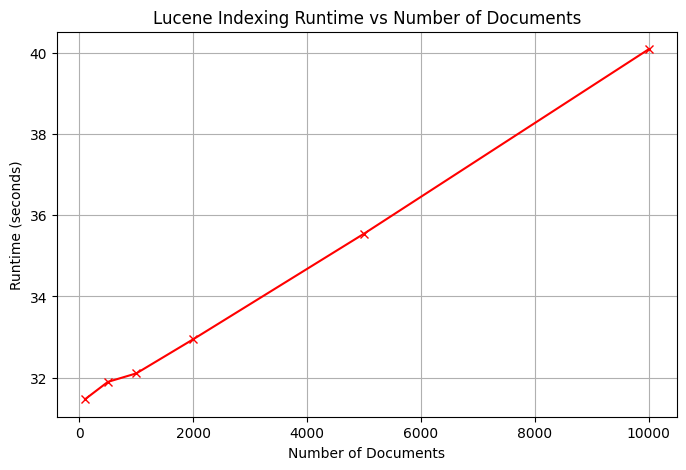

In [22]:
import time
import matplotlib.pyplot as plt

# Define source, input, and index
source = "wiki_data2.jsonl"
input = "input"
index = "indexes/wiki_index"

# Creates a folder/ directory called "input" to store the json file being indexed using pyserini
os.makedirs(input, exist_ok=True)

# Document counts to test 
# Test in increments to measure how indexing time grows as document count increases
doc_counts = [100, 500, 1000, 2000, 5000, 10000]

# Define variables to store times and lines
times = []
lines = []

# Read source file and store lines in memory
with open(source, "r", encoding="utf-8") as fin:
    for line in fin:
        lines.append(json.loads(line))

# Loop through document counts
for n in doc_counts:

    # Write first n documents to pyserini input file
    # Opens a new JSONL file that pyserini will index. File is overwritten for each value of n
    with open(os.path.join(input, "wiki_docs_subset.jsonl"), "w", encoding="utf-8") as fout:
        for i in range(n):
            data = lines[i]

            # convert original wikipedia doc to pyserini format
            pyserini_doc = {
                "id": data["url"],                 # url acts as unique identifier
                "contents": f"{data['title']}\n\n{data['text']}",  # title + text combined for indexing
                "title": data["title"]             # title
            }

            # writes one JSON object per line
            fout.write(json.dumps(pyserini_doc) + "\n")

    # Remove previous index if exists
    # Indexing starts from scratch
    if os.path.exists(index):
        subprocess.run(["rm", "-rf", index])

    # Build Lucene index and record time
    cmd = [
        "python", "-m", "pyserini.index.lucene",
        "--collection", "JsonCollection",   # input format
        "--input", input,               # directory containing jsonl docs
        "--index", index,               # output into indexes/wiki_index folder
        "--generator", "DefaultLuceneDocumentGenerator",
        "--threads", "1",
        "--storePositions",
        "--storeDocvectors",
        "--storeRaw"
    ]

    # Starts timer before indexing
    start_time = time.time()

    # Run indexing commands
    subprocess.run(cmd, check=True)

    # Stops timer after indexing finishes
    end_time = time.time()

    # Append runtime for current document count
    times.append(end_time - start_time)
    print(f"Indexed {n} docs in {times[-1]:.2f} seconds")

# Plot runtime vs document count
plt.figure(figsize=(8, 5))
plt.plot(doc_counts, times, marker="x", color="red")
plt.title("Lucene Indexing Runtime vs Number of Documents")
plt.xlabel("Number of Documents")
plt.ylabel("Runtime (seconds)")
plt.grid(True)
plt.show()
